## Import Packages

In [2]:
import vaex
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn import metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### Prepare Data

In [3]:
# create datasets
timeBs = [1,2,4,6]
resolutions = [5,6]
data_groups = []

for t in timeBs:
    for r in resolutions:
        hdf = vaex.open("data/trips/trips_grouped_" + str(t) + "h_r" + str(r) + ".hdf5")
        df = hdf.to_pandas_df()
        df_name = str("df_" + str(t) + "h_r" + str(r)) 
        data_groups.append((df_name, df))

In [21]:
# unify column names 
for info, data in data_groups:
  print(f"Dataset with spatial/temporal resolution of: {info}")
  data.columns.values[5] = 'ts_start_hour'
  data.columns.values[7] = 'start_hour_sin'
  data.columns.values[9] = 'pickup_hex'
  print(data.columns)

Dataset with spatial/temporal resolution of: df_1h_r5
Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_hour', 'start_1_hour', 'start_hour_sin',
       'start_1_hour_cos', 'pickup_hex', 'demand', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'Company_encoded', 'Taxi ID_encoded', 'Payment Type_Dispute',
       'Payment Type_Unknown', 'Payment Type_Prcard', 'Payment Type_Cash',
       'Payment Type_Credit Card', 'Payment Type_Pcard',
       'Payment Type_No Charge'],
      dtype='object')
Dataset with spatial/temporal resolution of: df_1h_r6
Index(['start_day', 'start_month', 'start_weekday', 'start_weekday_sin',
       'start_weekday_cos', 'ts_start_hour', 'start_1_hour', 'start_hour_sin',
       'start_1_hour_cos', 'pickup_hex', 'demand', 'Trip Seconds',
       'Trip Miles', 'Fare', 'Tips', 'Tolls', 'Extras', 'Trip Total',
       'Company_encoded', 'Taxi ID_encoded', 'Payment Typ

In [22]:
# select features
weather_attributes = ['Temperature', 'Humidity', 'Precip.', 'cloud']
trip_attributes = ['ts_start_hour', 'start_weekday_sin', 'start_hour_sin', 'pickup_hex', 'demand']

# load weather 
weather_df = pd.read_pickle("data/weather.pickle")
weather_df = weather_df[weather_attributes]

### SVR Grid Search 

- epsilon 
- kernel type: linear, polynomial, RBF
- C: regularization parameter (correctly separate as many instances as possible rather than creating a hyperplane with the largest minimum margin)
- gamma (only for rbf): curvature in a decision boundary

In [ ]:
parameters = {
  'kernel': ('linear', 'rbf', 'poly'),
  'C':[1, 10],
  'gamma': [1e-7, 1e-4],
  'epsilon':[0.25,0.75]
  }

for info, data in data_groups:
  print(f"Dataset with spatial/temporal resolution of: {info}")
  data = data[trip_attributes]

  # merge weather 
  df = data.merge(weather_df, left_on='ts_start_hour', right_on='datetime', how='left')

  # target encoding of hexagon feature
  target_means = df.groupby('pickup_hex')['demand'].mean()
  df['hex_encoded'] = df['pickup_hex'].map(target_means)
  df.dropna(inplace=True)

  # assign target variable 
  X = df.drop(['demand', 'pickup_hex', 'ts_start_hour'], axis=1)
  y = df['demand']
  
  #scale features 
  scaler = StandardScaler()
  scaler.fit(X)
  X_scaled = scaler.transform(X)

  #tain test split
  X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

  #grid search 
  svr = SVR()
  grid = GridSearchCV(svr, parameters, n_jobs=-1, scoring='neg_mean_squared_error', verbose=2, cv=3) 
  grid.fit(X_train,y_train)
  grid_df = pd.DataFrame(grid.cv_results_["params"])
  grid_df["loss"] = grid.cv_results_["mean_test_score"]  

  print(grid.best_params_)
  print(grid_df)

### Census Tract Comparison

In [25]:
#  1h, res5 
df = data_groups[0][1]
df = df.merge(weather_df, left_on='ts_start_hour', right_on='datetime', how='left')
df = df[['Temperature', 'Humidity', 'Precip.', 'cloud', 'ts_start_hour', 'start_weekday_sin', 'start_hour_sin', 'pickup_hex', 'demand']]
target_means = df.groupby('pickup_hex')['demand'].mean()
df['hex_encoded'] = df['pickup_hex'].map(target_means)
df.dropna(inplace=True)
X = df.drop(['demand', 'pickup_hex', 'ts_start_hour'], axis=1)
y = df['demand']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

svr = SVR(kernel='linear', C=10, epsilon=0.25, gamma=1e-07)
svr.fit(X_train, y_train)

SVR(C=10, epsilon=0.25, gamma=1e-07, kernel='linear')

In [26]:
# evaluation 1h, r5
y_pred = svr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

Mean Squared Error: 343266.20633396995
Mean Absolute Error: 254.99522480296753
R-squared: 0.7007637490151778


In [5]:
# run with 1h, census tract 
hdf = vaex.open("data/trips/trips_grouped_1h_census.hdf5")
df = hdf.to_pandas_df()
df = df.merge(weather_df, left_on='ts_start_1_hour', right_on='datetime', how='left')
df = df[['Temperature', 'Humidity', 'Precip.', 'cloud', 'ts_start_1_hour', 'start_weekday_sin', 'start_1_hour_sin', 'Pickup Census Tract', 'demand']]
target_means = df.groupby('Pickup Census Tract')['demand'].mean()
df['census_encoded'] = df['Pickup Census Tract'].map(target_means)
df.dropna(inplace=True)
X = df.drop(['demand', 'Pickup Census Tract', 'ts_start_1_hour'], axis=1)
y = df['demand']

scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3)

svr = SVR(kernel='linear', C=10, epsilon=0.25, gamma=1e-07)
svr.fit(X_train, y_train)

In [ ]:
# evaluation 1h, census tract
y_pred = svr.predict(X_test)

# Calculate evaluation metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print evaluation results
print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)
print("R-squared:", r2)

### Visualization 

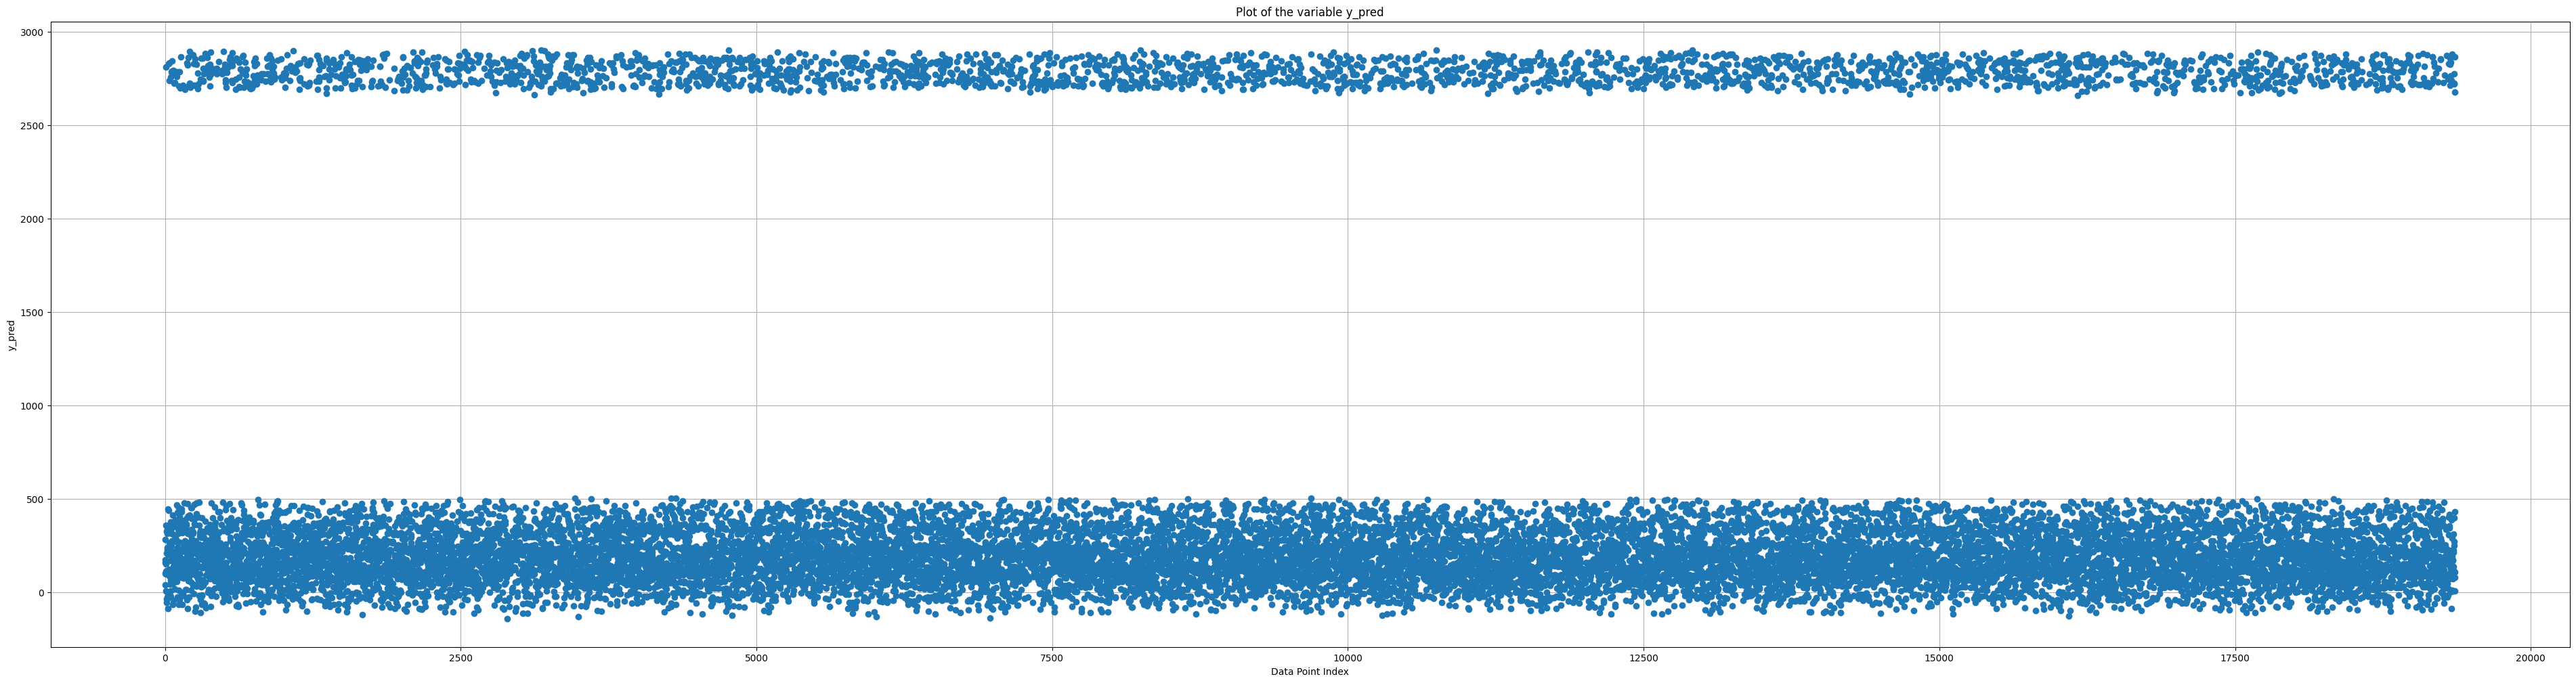

In [27]:
# plot y_pred
x = np.arange(len(y_pred))
plt.figure(figsize=(48, 12))
plt.plot(x, y_pred, marker='o', linestyle="")
plt.xlabel('Data Point Index')
plt.ylabel('y_pred')
plt.title('Plot of the variable y_pred')
plt.grid(True)
plt.show()

In [30]:
target_means

pickup_hex_5
8526641bfffffff       1.178599
85266453fffffff      61.398958
85266457fffffff       1.271887
852664c3fffffff    2764.088709
852664cbfffffff     401.646992
852664cffffffff     136.254367
852664dbfffffff     180.635347
85275937fffffff     201.429730
None                302.321192
Name: demand, dtype: float64

The linear kernel predicts demand close to the target encoded mean of the hexagons.

### Hexagon Resolution
We decided to use resoltuion 5 and 6 for gridsearch as for a hexagon resolution of 7, a significant portion of hexagons do not have rides in most time buckets. 

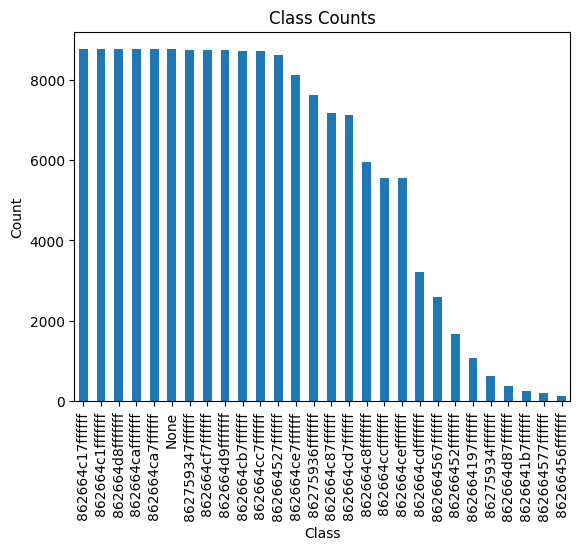

In [28]:
df = data_groups[1][1]

df = df[['demand', 'pickup_hex']]

df = df['pickup_hex'].value_counts()

df.plot(kind='bar')

# Set the plot labels and title
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Class Counts')

# Display the plot
plt.show()

### Improvements

Futher improvements in a follow-up project could be to use less categorical variables. Hex_id was encoded with target encoding, so another approach could be to transform hex values back to continuous variables instead of using target encoding.  

In [ ]:
#transform hex to numerical
### df['lat'] = df['pickup_hex'].apply(lambda x: h3.h3_to_geo(x)[0])
### df['long'] = df['pickup_hex'].apply(lambda x: h3.h3_to_geo(x)[1])
### df = df.drop(['hex', 'pickup_hex_7'], axis=1)

Another approach could be to build another nested loop that creates SVR for multiple Hexagons, by splitting the data to individual hexagon datasets. With this approach, 'real' spatio-temporal forecasting is possible. For example the resolution of 5 created 9 hexagons that would result in 9 SVM predicting the target variable. 

Also, POI data can be used to create further hexagon related features, e.g. the density of restaurants and bars per hexagon that we calculated in the descriptive part.  

As seen in the data description part, some extreme target variable values exist, so scaling the target variable or excluding outliers could achieve better results for SVR. Therefore we could use the transformed target regressor. 

In [ ]:
### regressor = SVR(kernel='linear')
### transformed_regressor = TransformedTargetRegressor(regressor=regressor,
                                                  ###   func=scaler,
                                                  ###   inverse_func=inverse_scaler)
### transformed_regressor.fit(X_train, y_train)

Lastly, we could use cross-validation and test more model parameters in grid search. For now we decided to choose two initial values for each parameter to get a first 'trend', because of the runtime. 